In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from numpy.polynomial import Polynomial
import math 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import kpss
import warnings 
warnings.filterwarnings("ignore")


In [29]:
df = pd.read_excel("../Graduates From University First Degree Courses By Type Of Course And Sex, Annual.xlsx", skiprows=10, nrows=32)
df.head()

,Data Series,2022,2021,2020,2019,2018,2017,2016,2015,2014,...,2002,2001,2000,1999,1998,1997,1996,1995,1994,1993
0,Males,10491,10075,9880,9429,9404,8963,7703,7872,7756,...,4858,4735,4536,4573,4455,4276,4022,4003,3889,3565
1,Males: Education,62,46,58,54,73,65,79,99,124,...,63,63,35,44,56,45,46,12,na,na
2,Males: Applied Arts,135,180,163,186,189,175,173,187,165,...,na,na,na,na,na,na,na,na,na,na
3,Males: Humanities & Social Sciences,1160,1192,1180,1119,1095,1078,803,743,803,...,591,534,574,576,547,554,497,497,512,481
4,Males: Mass Communication & Information Science,86,92,82,74,68,78,35,42,44,...,30,39,34,19,27,28,na,na,na,na


What if we split it by gender only?

In [30]:
gender_df = df.transpose()
gender_df.rename(index={"Data Series":"index"},inplace=True)

gender_df.columns = gender_df.iloc[0] #set first row as header
gender_df = gender_df[1:] #drops old header

#reduce to just gender with no categories
gender_df = gender_df.loc[:,['Males','Females']]
gender_df['Males'] = gender_df['Males'].astype(float)
gender_df['Females'] = gender_df['Females'].astype(float)
gender_df = gender_df.reset_index().rename(columns={'index': 'Year'})
gender_df.head()

index,Year,Males,Females
0,2022,10491.0,10316.0
1,2021,10075.0,9686.0
2,2020,9880.0,9938.0
3,2019,9429.0,9744.0
4,2018,9404.0,9593.0


In [31]:
stats = gender_df[['Males','Females']].describe()
print(stats)
#so more female graudates as compared to male graduates (~6514 females to ~6336 males)
avg_males = stats['Males'].loc['mean']
avg_females = stats['Females'].loc['mean']
pct_females_over_males = round(((avg_females - avg_males) / avg_males)*100 , 2)
print(f"\nThere are approximately {pct_females_over_males}% more female graduates than male graduates.")

index         Males       Females
count     30.000000     30.000000
mean    6335.766667   6514.233333
std     2099.617480   2078.556954
min     3565.000000   3625.000000
25%     4613.500000   4948.500000
50%     5779.500000   5853.000000
75%     7748.000000   7973.250000
max    10491.000000  10316.000000

There are approximately 2.82% more female graduates than male graduates.


In [32]:
df_long = gender_df.melt(id_vars='Year', var_name='Gender', value_name='Frequency')
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')
df_long['Frequency'] = pd.to_numeric(df_long['Frequency'], errors='coerce')
df_long['Gender'] = df_long['Gender'].str.strip().str.title()


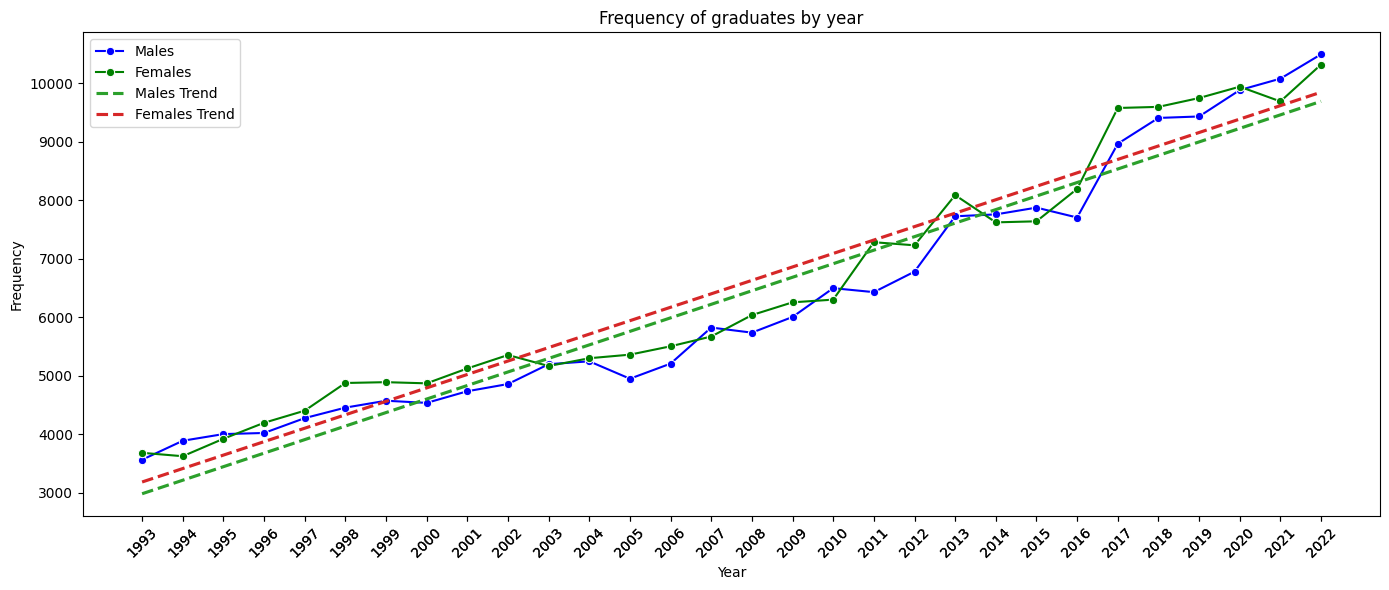

In [33]:
plt.figure(figsize=(14, 6))
plt.title("Frequency of graduates by year")
gender_colors = {'Males': 'blue', 'Females': 'green'}

#line chart
sns.lineplot(data=df_long, x='Year', y='Frequency', hue='Gender', marker='o',
             palette=gender_colors)


results_metric = {}
polynomial_equations = []
    
for gender in ['Males','Females']:
    subset = df_long[df_long['Gender'] == gender]
    x = subset['Year'].values
    y = subset['Frequency'].values
   
    #plot regression line (dotted)
    sns.regplot(
        data=subset, x='Year', y='Frequency',
        scatter=False, ci=None, label=f"{gender} Trend",
        line_kws={'linestyle': 'dashed'}
    )
    
    
    # Linear Regression
    linear_poly = Polynomial.fit(x, y, deg=1).convert()    
    linear_pred = linear_poly(x)
    linear_mse = mean_squared_error(y, linear_pred)
    linear_rmse = np.sqrt(linear_mse)
    linear_r2 = r2_score(y, linear_pred) #goodness to fit
    #r2 = 1 - (RSS/TSS)
    #RSS means residual sum of square; TSS means residual sum of square
    #r2 evalutes the explantory power of the model
    
    linear_eq  = f"{gender} linear eqn: y = {linear_poly.coef[1]:.2f}x {linear_poly.coef[0]:.2f}"

    # Quad Regression
    quad_poly = Polynomial.fit(x, y, deg=2).convert()
    quad_pred = quad_poly(x)
    quad_mse = mean_squared_error(y, quad_pred)
    quad_rmse = np.sqrt(quad_mse)
    quad_r2 = r2_score(y, quad_pred) #goodness to fit
    quad_eq  = f"{gender} quad eqn: y = {quad_poly.coef[2]:.2f}x² + {quad_poly.coef[1]:.2f}x + {quad_poly.coef[0]:.2f}"
    
    # Save results
    results_metric[gender] = {
        'Linear R2 Score' : linear_r2,
        'Linear RMSE': linear_rmse,
        'Quadratic R2 score' : quad_r2,
        'Quadratic RMSE': quad_rmse
    }
    polynomial_equations.append(linear_eq)
    polynomial_equations.append(quad_eq)

    
plt.xticks(df_long['Year'],rotation=45)
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


In [34]:
# Display results
for gender, metrics in results_metric.items():
    print(f"\n{gender} Regression Errors:")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.2f}")


Males Regression Errors:
  Linear R2 Score: 0.94
  Linear RMSE: 507.99
  Quadratic R2 score: 0.99
  Quadratic RMSE: 232.65

Females Regression Errors:
  Linear R2 Score: 0.95
  Linear RMSE: 475.90
  Quadratic R2 score: 0.97
  Quadratic RMSE: 331.08


In [35]:
for index,val in enumerate(polynomial_equations):
    print(f"{val}")

Males linear eqn: y = 231.17x -457730.80
Males quad eqn: y = 6.75x² + -26872.50x + 26747064.68
Females linear eqn: y = 229.62x -454442.16
Females quad eqn: y = 5.11x² + -20287.88x + 20139615.78


Okay, so what is the year with the largest gap for both males and females?

In [36]:
#gap = males - females
gender_gap_df = gender_df.copy()
gender_gap_df['Gap'] = gender_gap_df['Males'] - gender_gap_df['Females']
gender_gap_df.head()

index,Year,Males,Females,Gap
0,2022,10491.0,10316.0,175.0
1,2021,10075.0,9686.0,389.0
2,2020,9880.0,9938.0,-58.0
3,2019,9429.0,9744.0,-315.0
4,2018,9404.0,9593.0,-189.0


In [37]:
highest_male_gap = gender_gap_df.loc[gender_gap_df.Gap.idxmax()]
highest_female_gap = gender_gap_df.loc[gender_gap_df.Gap.idxmin()]
print(f"The year with the highest male gap is {highest_male_gap.Year}with {highest_male_gap.Gap:.0f}, \nand the year with the highest female gap is {highest_female_gap.Year}with {highest_female_gap.Gap:.0f}.")


The year with the highest male gap is 2021 with 389, 
and the year with the highest female gap is 2011 with -853.


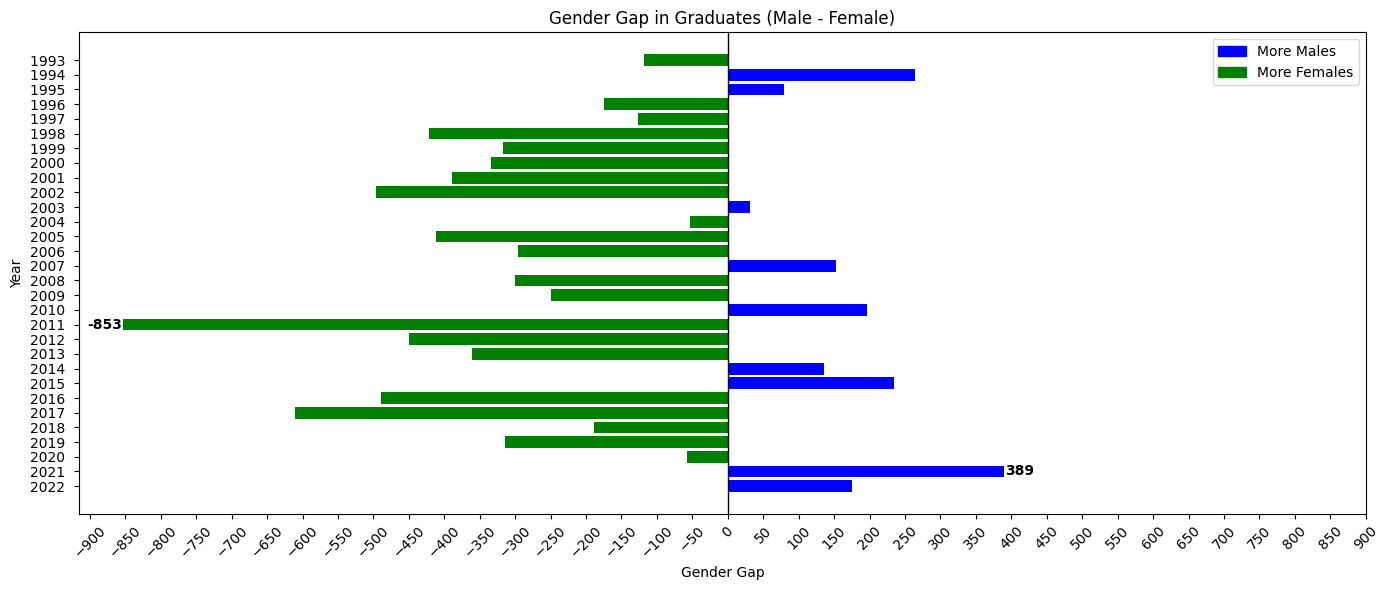

In [38]:
#That being said, I would also like to show the gender gap between graduates year on year 
# on a divergence bar chart
plt.figure(figsize=(14, 6))
plt.barh(gender_gap_df['Year'], gender_gap_df['Gap'], color=gender_gap_df['Gap'].apply(lambda x: gender_colors.get('Males') if x >= 0 else gender_colors.get('Females')))

plt.axvline(0, color='black', linewidth=1)

# Annotations for max gaps
max_male_row = gender_gap_df.loc[gender_gap_df['Gap'].idxmax()]
max_female_row = gender_gap_df.loc[gender_gap_df['Gap'].idxmin()]
plt.text(
    max_male_row['Gap'] + 2, max_male_row['Year'], 
    f"{max_male_row['Gap']:.0f}", va='center', fontsize=10, fontweight='bold'
)
plt.text(
    max_female_row['Gap'] - 2, max_female_row['Year'], 
    f"{max_female_row['Gap']:.0f}", va='center', ha='right', fontsize=10, fontweight='bold'
)

gap_max = gender_gap_df['Gap'].abs().max()
gap_limit = int(math.ceil(gap_max / 50.0) * 50)
tick_range = np.arange(-gap_limit, gap_limit + 1, 50)

plt.xticks(tick_range,rotation=45)
plt.title('Gender Gap in Graduates (Male - Female)')
plt.ylabel('Year')
plt.xlabel('Gender Gap')

blue_patch = mpatches.Patch(color='blue', label='More Males')
green_patch = mpatches.Patch(color='green', label='More Females')
plt.legend(handles=[blue_patch, green_patch])

plt.tight_layout()
plt.show()


So what has contributed to these high gap number for female in 2011 and high gap number for male in 2021?
Let's use our categories to find out

In [39]:
#first we will need to slice data set according to male categories and female categories
df_courses = df.copy().transpose()
df_courses.rename(index={"Data Series":"Year"},inplace=True)
df_courses.columns = df_courses.iloc[0]
df_courses = df_courses.iloc[1: , :]
df_courses.index = pd.to_numeric(df_courses.index)
df_courses = df_courses.loc[[2021,2011]]
df_courses = df_courses.drop(columns=['Males','Females'])

In [40]:
df_courses_m = df_courses.filter(like='Male', axis=1)
df_courses_f = df_courses.filter(like='Female', axis=1)

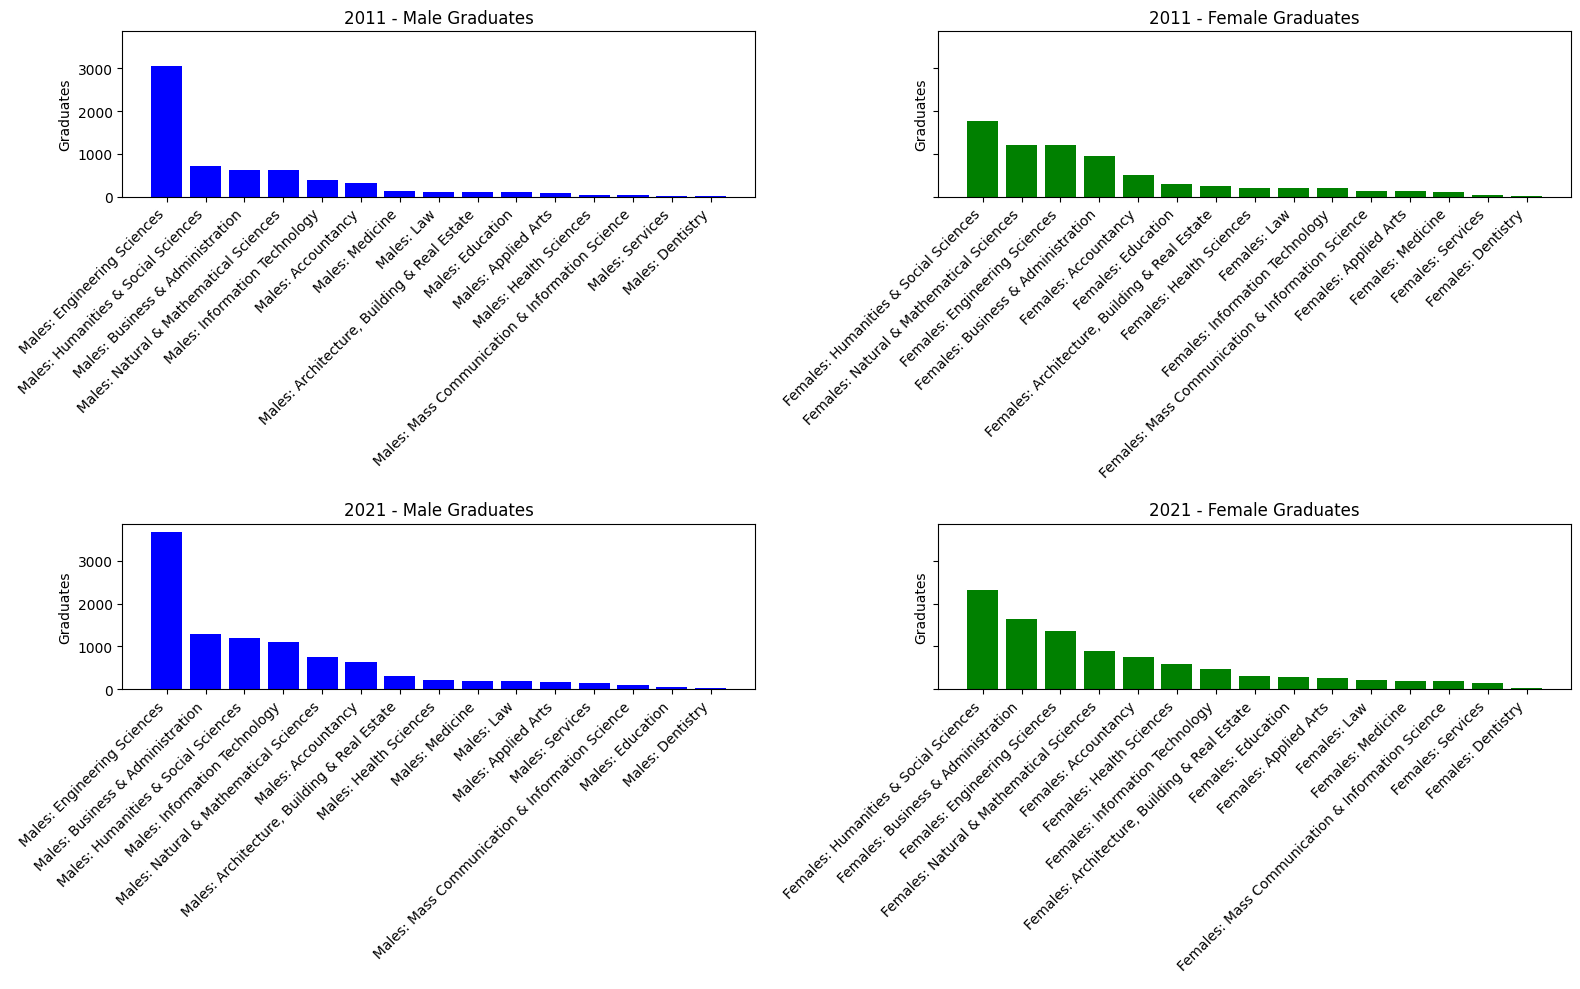

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharey=True)

titles = [
    "2011: Male Graduates",
    "2011:  Female Graduates",
    "2021:  Male Graduates",
    "2021:  Female Graduates"
]

# Plotting helper
def plot_bar(ax, data_row, gender, year):
    sorted_data = data_row.sort_values(ascending=False)
    ax.bar(sorted_data.index, sorted_data.values,
           color='blue' if gender == 'Male' else 'green')
    ax.set_title(f"{year} - {gender} Graduates")
    ax.set_xticklabels(sorted_data.index, rotation=45, ha='right')
    ax.set_ylabel("Graduates")

# Top row: 2011
plot_bar(axes[0, 0], df_courses_m.loc[2011], 'Male', 2011)
plot_bar(axes[0, 1], df_courses_f.loc[2011], 'Female', 2011)

# Bottom row: 2021
plot_bar(axes[1, 0], df_courses_m.loc[2021], 'Male', 2021)
plot_bar(axes[1, 1], df_courses_f.loc[2021], 'Female', 2021)

# Final formatting
plt.tight_layout()
plt.show()


Time series analysis (ARIMA)

In [42]:
ts_df = gender_df.copy()
ts_df['Year'] = ts_df['Year'].astype(str)
ts_df['Year'] = ts_df['Year'].str.extract(r'(\d{4})')
ts_df = ts_df.dropna(subset=['Year'])
# ts_df.index = pd.to_datetime(ts_df['Year'], format='%Y')  # Make Year a datetime index
ts_df.set_index('Year', inplace=True)
ts_df.index = pd.to_datetime(ts_df.index, format='%Y')

In [43]:
ts_df = ts_df.sort_index()
ts_df

index,Males,Females
Year,,
1993-01-01,3565.0,3683.0
1994-01-01,3889.0,3625.0
1995-01-01,4003.0,3923.0
1996-01-01,4022.0,4196.0
1997-01-01,4276.0,4403.0
1998-01-01,4455.0,4876.0
1999-01-01,4573.0,4890.0
2000-01-01,4536.0,4870.0
2001-01-01,4735.0,5124.0


In [44]:
from statsmodels.tsa.stattools import adfuller

# Check for stationarity for both genders
adf_m = adfuller(ts_df['Males'])
print("Males")
print(' ADF Statistic:', adf_m[0])
print(' p-value:', adf_m[1])

adf_f = adfuller(ts_df['Females'])
print("Females")
print(' ADF Statistic:', adf_f[0])
print(' p-value:', adf_f[1])


Males
 ADF Statistic: 1.568119428962783
 p-value: 0.9977587084930225
Females
 ADF Statistic: 0.33337458956875904
 p-value: 0.9788249333612307


what this means is there is females trend are non-stationary while male are weakly stationary

In [45]:
def kpss_test(series, signif=0.05):
    statistic, p_value, _, _ = kpss(series.dropna(), nlags="auto")
    print(f'KPSS statistic: {statistic:.3f}, p-value: {p_value:.3f}')


kpss_test(ts_df['Males'])
kpss_test(ts_df['Females'])


KPSS statistic: 0.825, p-value: 0.010
KPSS statistic: 0.825, p-value: 0.010


In [46]:
#bot males and females need to differentiate and hypo test again
ts_df['Males_diff'] = ts_df['Males'].diff()
result_diff_m = adfuller(ts_df['Males_diff'].dropna())
print('p-value:', result_diff_m[1])
print("rej H0, meaning if is non-stationary" if result_diff_m[1] > 0.05 else "do not rej H0, meaning is stationary")

ts_df['Females_diff'] = ts_df['Females'].diff()
result_diff_f = adfuller(ts_df['Females_diff'].dropna())
print('p-value:', result_diff_f[1])
print("rej H0, meaning if is non-stationary" if result_diff_f[1] > 0.05 else "do not rej H0, meaning is stationary")
#so now we know females should use ARIMA(p,1,q)

p-value: 0.9235904505768188
rej H0, meaning if is non-stationary
p-value: 2.566515911179971e-08
do not rej H0, meaning is stationary


In [47]:
ts_df['Males_diff_2'] = ts_df['Males_diff'].diff()
result_diff_2_m = adfuller(ts_df['Males_diff_2'].dropna())
print('p-value:', result_diff_2_m[1])
print("rej H0, meaning if is non-stationary" if result_diff_2_m[1] > 0.05 else "do not rej H0, meaning is stationary")


p-value: 0.46546918961461203
rej H0, meaning if is non-stationary


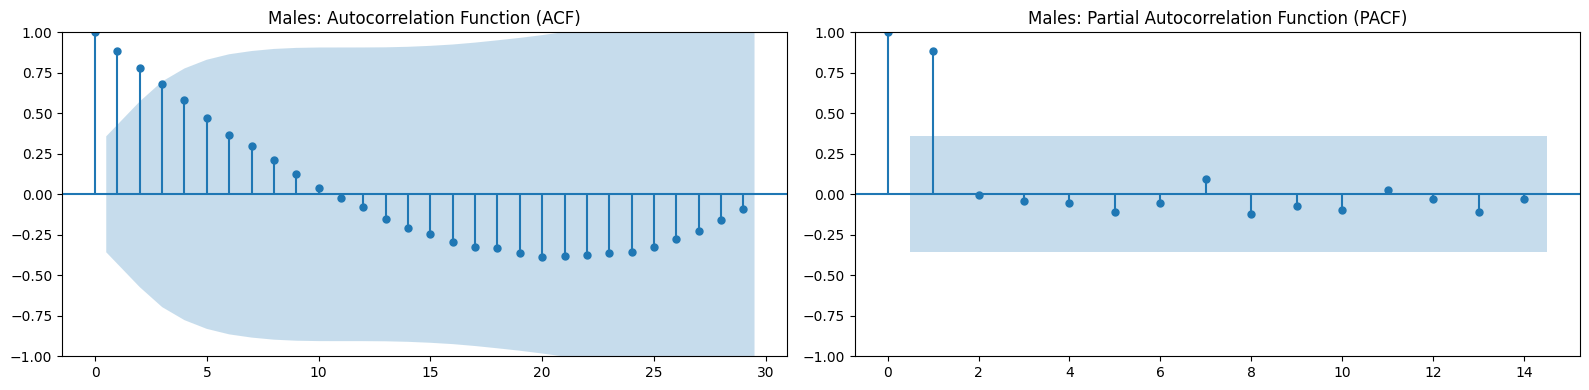

In [48]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF plot
plot_acf(ts_df['Males'].dropna(), lags=29, ax=axes[0])
axes[0].set_title('Males: Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(ts_df['Males'].dropna(), lags=14, ax=axes[1])
axes[1].set_title('Males: Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

By this ACF, as the dot crosses the area of statistical significance band (the shaded area) at 3. p = 3 in ARIMA model.
By PACF, as the PACF drops at 3, q=2.

Therefore, male should use ARIMA(3,0,2) model. This is technically ARMA(3,2)

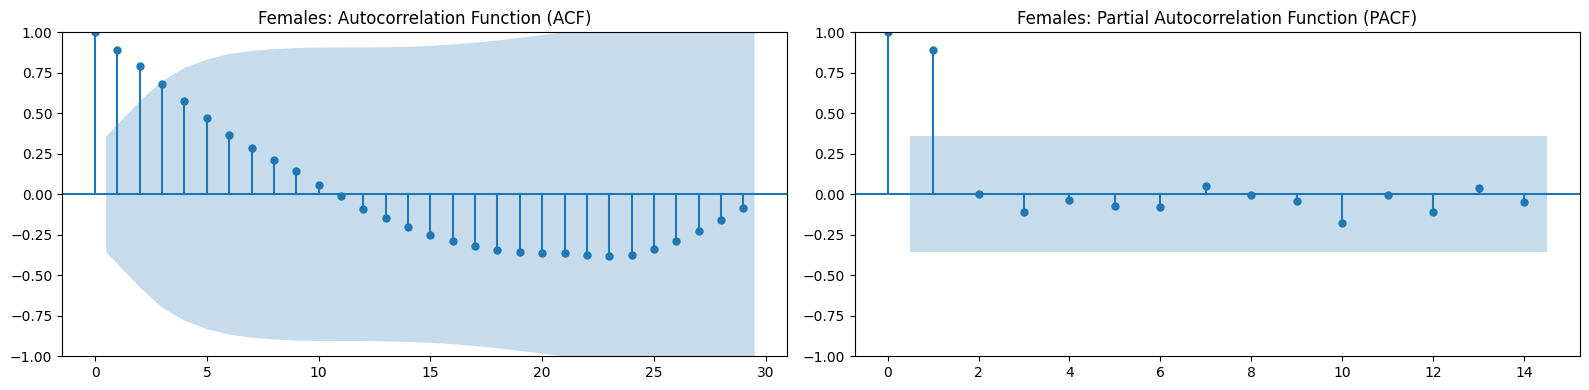

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF plot
plot_acf(ts_df['Females'].dropna(), lags=29, ax=axes[0])
axes[0].set_title('Females: Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(ts_df['Females'].dropna(), lags=14, ax=axes[1])
axes[1].set_title('Females: Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

similarly, females should use ARIMA(4,1,2)

In [50]:
#ARIMA MODEL NEED TO SORT DATA FROM OLDEST(INDEX 0) TO NEWEST (INDEX Nth)
from statsmodels.tsa.arima.model import ARIMA
ts_df_sorted = ts_df.sort_index(ascending=True)

# Split data into train and test
n_test = 5
train = ts_df_sorted.iloc[:-n_test]
test = ts_df_sorted.iloc[-n_test:]

# Fit ARIMA model
model = ARIMA(ts_df_sorted["Males"], order=(3,0,2))
model_fit = model.fit()

In [51]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
#ARIMA MODEL NEED TO SORT DATA FROM OLDEST(INDEX 0) TO NEWEST (INDEX Nth)
ts_df_sorted = ts_df.sort_index(ascending=True)
# test on last 5 years
n_test = 5
h_future = 3
train = ts_df_sorted.iloc[:-n_test]
test = ts_df_sorted.iloc[-n_test:]

def fit_and_eval(series, order):
    model = ARIMA(series, order=order)
    fit   = model.fit()

    steps_total = n_test + h_future
    fcst_all    = fit.forecast(steps=steps_total)

    fcst_test   = fcst_all.iloc[:n_test]
    fcst_future = fcst_all.iloc[n_test:]

    
    mse  = mean_squared_error(test[series.name], fcst_test)
    rmse = np.sqrt(mse)

    return fit, fcst_test, fcst_future, mse, rmse

# --- 4. Fit & forecast each series ---
m_fit, m_fcst_test, m_fcst_future, m_mse, m_rmse = \
    fit_and_eval(train['Males'],   order=(3,3,2))

f_fit, f_fcst_test, f_fcst_future, f_mse, f_rmse = \
    fit_and_eval(train['Females'], order=(3,1,2))



In [52]:
# 6. Evaluate with MSE (or RMSE)
print(f"Male RMSE:   {m_rmse:.2f}")
print(f"Female RMSE: {f_rmse:.2f}")

Male RMSE:   184.94
Female RMSE: 325.44


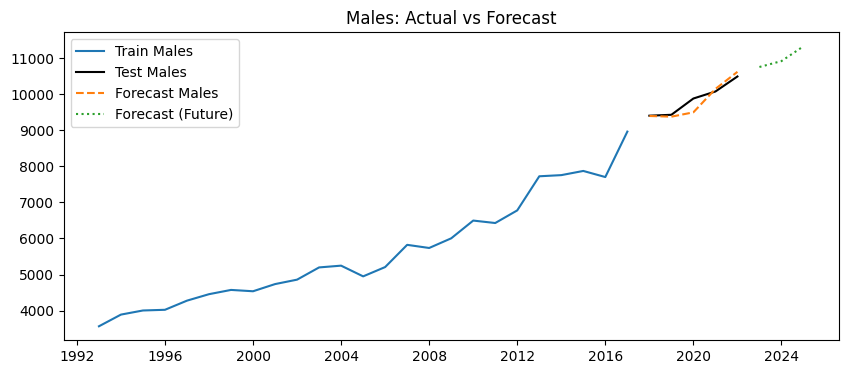

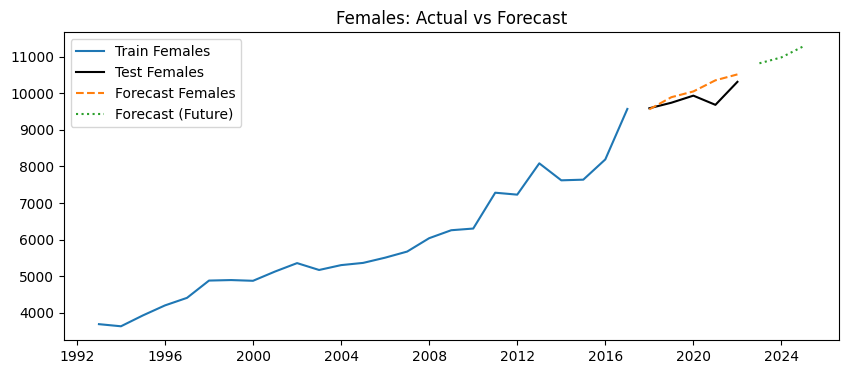

In [53]:
#to make sure index for the future forecast is shown
last_date    = ts_df_sorted.index[-1]
future_index = pd.date_range(
    start=last_date + pd.offsets.YearBegin(1),
    periods=h_future,
    freq='YS'
)

plt.figure(figsize=(10,4))
plt.plot(train.index, train['Males'],   label='Train Males')
plt.plot(test.index,  test['Males'],    label='Test Males',   color='black')
plt.plot(test.index,  m_fcst_test, label='Forecast Males', linestyle='--')
plt.plot(future_index,     m_fcst_future,      linestyle=':',  label='Forecast (Future)')
plt.title('Males: Actual vs Forecast')
plt.legend(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(train.index, train['Females'], label='Train Females')
plt.plot(test.index,  test['Females'],  label='Test Females', color='black')
plt.plot(test.index,  f_fcst_test,           label='Forecast Females', linestyle='--')
plt.plot(future_index,     f_fcst_future,      linestyle=':',  label='Forecast (Future)')

plt.title('Females: Actual vs Forecast')
plt.legend(); plt.show()

In [54]:
print(f"Male 3 year future figures: \n{m_fcst_future}")
print(f"\nFemale 3 year future figures: \n{f_fcst_future}")

Male 3 year future figures: 
2023-01-01    10754.325204
2024-01-01    10917.832581
2025-01-01    11328.722149
Freq: YS-JAN, Name: predicted_mean, dtype: float64

Female 3 year future figures: 
2023-01-01    10823.507954
2024-01-01    10985.466744
2025-01-01    11289.123513
Freq: YS-JAN, Name: predicted_mean, dtype: float64
